In [1]:
import os
import warnings
from itertools import combinations

import numpy as np
import torch

# Suppress potential optimization warnings for cleaner notebook
warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [2]:
# data generating helper functions
#function that defines the comparisons
def utility(X):
    """Given X, output corresponding utility (i.e., the latent function)"""
    # y is weighted sum of X, with weight sqrt(i) imposed on dimension i
    weighted_X = X * torch.sqrt(torch.arange(X.size(-1), dtype=torch.float) + 1)
    y = torch.sum(weighted_X, dim=-1)
    return y


def generate_data(n, dim=2):
    """Generate data X and y"""
    # X is randomly sampled from dim-dimentional unit cube
    # we recommend using double as opposed to float tensor here for
    # better numerical stability
    X = torch.rand(n, dim, dtype=torch.float64)
    y = utility(X)
    return X, y

#we need to change this to interaction with the llm
def generate_comparisons(y, n_comp, noise=0.1, replace=False):
    """Create pairwise comparisons with noise"""
    # generate all possible pairs of elements in y
    all_pairs = np.array(list(combinations(range(y.shape[0]), 2)))
    # randomly select n_comp pairs from all_pairs
    comp_pairs = all_pairs[
        np.random.choice(range(len(all_pairs)), n_comp, replace=replace)
    ]
    # add gaussian noise to the latent y values
    #change this part LLM api
    c0 = y[comp_pairs[:, 0]] + np.random.standard_normal(len(comp_pairs)) * noise
    c1 = y[comp_pairs[:, 1]] + np.random.standard_normal(len(comp_pairs)) * noise
    reverse_comp = (c0 < c1).numpy()
    comp_pairs[reverse_comp, :] = np.flip(comp_pairs[reverse_comp, :], 1)
    comp_pairs = torch.tensor(comp_pairs).long()

    return comp_pairs

In [3]:
#parameters
torch.manual_seed(123)
n = 50 if not SMOKE_TEST else 5
m = 100 if not SMOKE_TEST else 10
dim = 4
noise = 0.1

#generate data, initial data
train_X, train_y = generate_data(n, dim=dim)
#generating comparison based on the utility function
train_comp = generate_comparisons(train_y, m, noise=noise)

In [6]:
all_pairs = np.array(list(combinations(range(train_y.shape[0]), 2)))
# randomly select n_comp pairs from all_pairs
comp_pairs = all_pairs[
    np.random.choice(range(len(all_pairs)), 10, replace=False)
]
# add gaussian noise to the latent y values
#change this part LLM api
c0 = train_y[comp_pairs[:, 0]] + np.random.standard_normal(len(comp_pairs)) * noise
c1 = train_y[comp_pairs[:, 1]] + np.random.standard_normal(len(comp_pairs)) * noise
reverse_comp = (c0 < c1).numpy()


In [7]:
reverse_comp

array([False,  True, False, False, False,  True,  True,  True,  True,
        True])

In [ ]:
comp_pairs[reverse_comp, :] = np.flip(comp_pairs[reverse_comp, :], 1)
comp_pairs = torch.tensor(comp_pairs).long()

In [4]:
from botorch.fit import fit_gpytorch_mll
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch.models.transforms.input import Normalize


model = PairwiseGP(
    train_X,
    train_comp,
    input_transform=Normalize(d=train_X.shape[-1]),
)
mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
mll = fit_gpytorch_mll(mll)

In [ ]:
from scipy.stats import kendalltau


# Kendall-Tau rank correlation
def eval_kt_cor(model, test_X, test_y):
    pred_y = model.posterior(test_X).mean.squeeze().detach().numpy()
    return kendalltau(pred_y, test_y).correlation


n_kendall = 1000 if not SMOKE_TEST else 10

test_X, test_y = generate_data(n_kendall, dim=dim)
kt_correlation = eval_kt_cor(model, test_X, test_y)

print(f"Test Kendall-Tau rank correlation: {kt_correlation:.4f}")

Test Kendall-Tau rank correlation: 0.9031


In [ ]:
from botorch.acquisition.preference import AnalyticExpectedUtilityOfBestOption
from botorch.optim import optimize_acqf


def init_and_fit_model(X, comp):
    """Model fitting helper function"""
    model = PairwiseGP(
        X,
        comp,
        input_transform=Normalize(d=X.shape[-1]),
    )
    mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return mll, model


def make_new_data(X, next_X, comps, q_comp):
    """Given X and next_X,
    generate q_comp new comparisons between next_X
    and return the concatenated X and comparisons
    """
    # next_X is float by default; cast it to the dtype of X (i.e., double)
    next_X = next_X.to(X)
    next_y = utility(next_X)
    next_comps = generate_comparisons(next_y, n_comp=q_comp, noise=noise)
    comps = torch.cat([comps, next_comps + X.shape[-2]])
    X = torch.cat([X, next_X])
    return X, comps

In [ ]:
algos = ["EUBO", "rand"]

NUM_TRIALS = 3 if not SMOKE_TEST else 2
NUM_BATCHES = 30 if not SMOKE_TEST else 2

dim = 4
NUM_RESTARTS = 3
RAW_SAMPLES = 512 if not SMOKE_TEST else 8
q = 2  # number of points per query
q_comp = 1  # number of comparisons per query

# initial evals
best_vals = {}  # best observed values
for algo in algos:
    best_vals[algo] = []

# average over multiple trials
for i in range(NUM_TRIALS):
    torch.manual_seed(i)
    np.random.seed(i)
    data = {}
    models = {}

    # Create initial data
    init_X, init_y = generate_data(q, dim=dim)
    comparisons = generate_comparisons(init_y, q_comp, noise=noise)
    # X are within the unit cube
    bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])

    for algo in algos:
        best_vals[algo].append([])
        data[algo] = (init_X, comparisons)
        _, models[algo] = init_and_fit_model(init_X, comparisons)

        best_next_y = utility(init_X).max().item()
        best_vals[algo][-1].append(best_next_y)

    # we make additional NUM_BATCHES comparison queries after the initial observation
    for j in range(1, NUM_BATCHES + 1):
        for algo in algos:
            model = models[algo]
            if algo == "EUBO":
                # create the acquisition function object
                acq_func = AnalyticExpectedUtilityOfBestOption(pref_model=model)
                # optimize and get new observation
                next_X, acq_val = optimize_acqf(
                    acq_function=acq_func,
                    bounds=bounds,
                    q=q,
                    num_restarts=NUM_RESTARTS,
                    raw_samples=RAW_SAMPLES,
                )
            else:
                # randomly sample data
                next_X, _ = generate_data(q, dim=dim)

            # update data
            X, comps = data[algo]
            X, comps = make_new_data(X, next_X, comps, q_comp)
            data[algo] = (X, comps)

            # refit models
            _, models[algo] = init_and_fit_model(X, comps)

            # record the best observed values so far
            max_val = utility(X).max().item()
            best_vals[algo][-1].append(max_val)

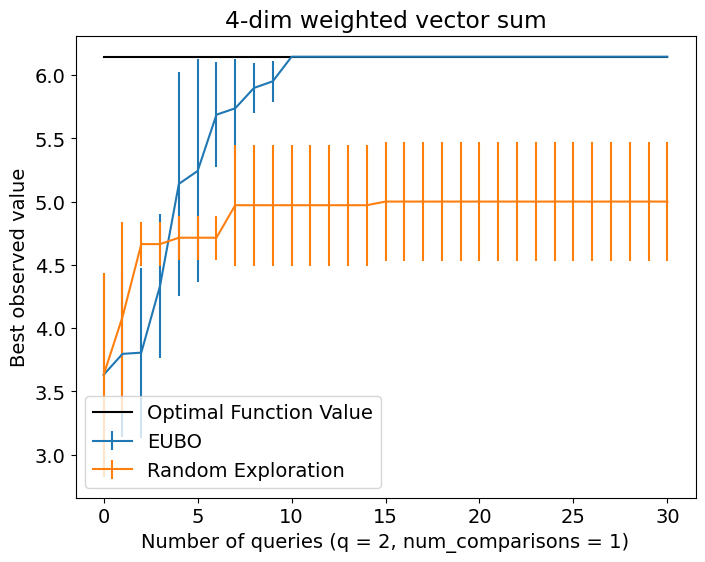

In [ ]:
from matplotlib import pyplot as plt


%matplotlib inline

plt.rcParams.update({"font.size": 14})

algo_labels = {
    "rand": "Random Exploration",
    "EUBO": "EUBO",
}


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(y.shape[0])


# the utility function is maximized at the full vector of 1
optimal_val = utility(torch.tensor([[1] * dim])).item()
iters = list(range(NUM_BATCHES + 1))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# plot the optimal value
ax.plot(
    iters,
    [optimal_val] * len(iters),
    label="Optimal Function Value",
    color="black",
    linewidth=1.5,
)

# plot the the best observed value from each algorithm
for algo in algos:
    ys = np.vstack(best_vals[algo])
    ax.errorbar(
        iters, ys.mean(axis=0), yerr=ci(ys), label=algo_labels[algo], linewidth=1.5
    )

ax.set(
    xlabel=f"Number of queries (q = {q}, num_comparisons = {q_comp})",
    ylabel="Best observed value",
    title=f"{dim}-dim weighted vector sum",
)
ax.legend(loc="best")